# Predict Future Sales

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.
File descriptions

    sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
    test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
    sample_submission.csv - a sample submission file in the correct format.
    items.csv - supplemental information about the items/products.
    item_categories.csv  - supplemental information about the items categories.
    shops.csv- supplemental information about the shops.

Data fields

    ID - an Id that represents a (Shop, Item) tuple within the test set
    shop_id - unique identifier of a shop
    item_id - unique identifier of a product
    item_category_id - unique identifier of item category
    item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
    item_price - current price of an item
    date - date in format dd/mm/yyyy
    date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
    item_name - name of item
    shop_name - name of shop
    item_category_name - name of item category


* Import all the required libraries
* Import all the datasets
* Merge all the dataset to get the final training datasets
* Downcast the data to save memory
* Set the date column as index
* Check the null values in data
* Identify the pattern of sales of Item and Item Category on Monthly basis
* Create and prepare the DataFrame to predict the trend using Time Seies Forcasting
* Check the stationarity of the trend using AdFuller Moethod and if not stationary, then make it stationary
* Find out the p, q value for ARIMA model using PACF and ACF plot
* Build an ARIMA model and fit the train data and predict the trend using test data
* Tune the Random Forest model and XGBoost model using RandomizedSarchCV
* Choose the model on the basis of the monthly sales of Item
* Store the result in Destination File

# Import the required Libraries

In [1]:
import pandas as pd 
pd.set_option('display.max_columns', 400)
pd.set_option('display.width', 1000)
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

# Import all the required datasets

In [2]:
sales_data = pd.read_csv("sales_train.csv")
item_data = pd.read_csv("items.csv")
item_cat = pd.read_csv("item_categories.csv")
shops_data = pd.read_csv("shops.csv")
test_data = pd.read_csv("test.csv")

In [3]:
sales_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
sal_dup = sales_data[sales_data.duplicated()]
sal_dup

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


In [5]:
item_data.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
item_dup = item_data[item_data.duplicated()]
item_dup

,item_name,item_id,item_category_id


In [7]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
cat_dup = item_cat[item_cat.duplicated()]
cat_dup

,item_category_name,item_category_id


In [9]:
shops_data.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [10]:
test_data.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [11]:
sales_shop = pd.merge(sales_data, shops_data, on = "shop_id")

In [12]:
sales_shop.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name
0,02.01.2013,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир"""
1,10.01.2013,0,59,22151,399.0,1.0,"Ярославль ТЦ ""Альтаир"""
2,04.01.2013,0,59,5603,699.0,1.0,"Ярославль ТЦ ""Альтаир"""
3,19.01.2013,0,59,5587,199.0,2.0,"Ярославль ТЦ ""Альтаир"""
4,31.01.2013,0,59,5613,5571.0,1.0,"Ярославль ТЦ ""Альтаир"""


In [13]:
dup1 = sales_shop[sales_shop.duplicated()]
dup1

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name
155807,12.07.2014,18,25,3423,999.0,1.0,"Москва ТРК ""Атриум"""
475918,23.03.2014,14,21,3423,999.0,1.0,"Москва МТРЦ ""Афи Молл"""
1809197,05.01.2013,0,54,20130,149.0,1.0,"Химки ТЦ ""Мега"""
2047304,23.02.2014,13,50,3423,999.0,1.0,"Тюмень ТЦ ""Гудвин"""
2052446,01.05.2014,16,50,3423,999.0,1.0,"Тюмень ТЦ ""Гудвин"""
2149688,31.12.2014,23,42,21619,499.0,1.0,"СПб ТК ""Невский Центр"""


In [14]:
sales_shop_item = pd.merge(sales_shop, item_data, on = "item_id")

In [15]:
sales_shop_item.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37
1,02.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37
2,03.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37
3,20.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37
4,23.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37


In [16]:
dup2 = sales_shop_item[sales_shop_item.duplicated()]
dup2

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id
1242959,12.07.2014,18,25,3423,999.0,1.0,"Москва ТРК ""Атриум""","Far Cry 3 (Classics) [Xbox 360, русская версия]",23
1243108,23.03.2014,14,21,3423,999.0,1.0,"Москва МТРЦ ""Афи Молл""","Far Cry 3 (Classics) [Xbox 360, русская версия]",23
1244060,23.02.2014,13,50,3423,999.0,1.0,"Тюмень ТЦ ""Гудвин""","Far Cry 3 (Classics) [Xbox 360, русская версия]",23
1244071,01.05.2014,16,50,3423,999.0,1.0,"Тюмень ТЦ ""Гудвин""","Far Cry 3 (Classics) [Xbox 360, русская версия]",23
2429125,31.12.2014,23,42,21619,499.0,1.0,"СПб ТК ""Невский Центр""",ЧЕЛОВЕК ДОЖДЯ (BD),37
2603064,05.01.2013,0,54,20130,149.0,1.0,"Химки ТЦ ""Мега""",УЧЕНИК ЧАРОДЕЯ (регион),40


In [17]:
data_set = pd.merge(sales_shop_item, item_cat, on = "item_category_id")

In [18]:
data_set.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,02.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,03.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,20.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,23.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


In [19]:
dup3 = data_set[data_set.duplicated()]
dup3

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
160400,31.12.2014,23,42,21619,499.0,1.0,"СПб ТК ""Невский Центр""",ЧЕЛОВЕК ДОЖДЯ (BD),37,Кино - Blu-Ray
678476,05.01.2013,0,54,20130,149.0,1.0,"Химки ТЦ ""Мега""",УЧЕНИК ЧАРОДЕЯ (регион),40,Кино - DVD
1785853,12.07.2014,18,25,3423,999.0,1.0,"Москва ТРК ""Атриум""","Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360
1786002,23.03.2014,14,21,3423,999.0,1.0,"Москва МТРЦ ""Афи Молл""","Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360
1786954,23.02.2014,13,50,3423,999.0,1.0,"Тюмень ТЦ ""Гудвин""","Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360
1786965,01.05.2014,16,50,3423,999.0,1.0,"Тюмень ТЦ ""Гудвин""","Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360


In [20]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int64  
 2   shop_id             int64  
 3   item_id             int64  
 4   item_price          float64
 5   item_cnt_day        float64
 6   shop_name           object 
 7   item_name           object 
 8   item_category_id    int64  
 9   item_category_name  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 246.4+ MB


# Downcast the Data

In [21]:
def red_mem(df):
    flt_col = [i for i in df if df[i].dtype == "float64"]
    int_col = [i for i in df if df[i].dtype == "int64"]
    df[flt_col] = df[flt_col].astype(np.float32)
    df[int_col] = df[int_col].astype(np.int32)
    return df

In [22]:
data = red_mem(data_set)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int32  
 2   shop_id             int32  
 3   item_id             int32  
 4   item_price          float32
 5   item_cnt_day        float32
 6   shop_name           object 
 7   item_name           object 
 8   item_category_id    int32  
 9   item_category_name  object 
dtypes: float32(2), int32(4), object(4)
memory usage: 179.2+ MB


In [24]:
data["date"] = data["date"].apply(lambda x: x.replace(".","/"))

In [25]:
data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02/01/2013,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,02/01/2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,03/01/2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,20/01/2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,23/01/2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


# Set the date column as Index

In [26]:
data["date"] = pd.to_datetime(data["date"], dayfirst=True)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int32         
 2   shop_id             int32         
 3   item_id             int32         
 4   item_price          float32       
 5   item_cnt_day        float32       
 6   shop_name           object        
 7   item_name           object        
 8   item_category_id    int32         
 9   item_category_name  object        
dtypes: datetime64[ns](1), float32(2), int32(4), object(3)
memory usage: 179.2+ MB


In [28]:
df = data.copy()

In [29]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,2013-01-02,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-01-02,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,2013-01-03,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,2013-01-20,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,2013-01-23,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int32         
 2   shop_id             int32         
 3   item_id             int32         
 4   item_price          float32       
 5   item_cnt_day        float32       
 6   shop_name           object        
 7   item_name           object        
 8   item_category_id    int32         
 9   item_category_name  object        
dtypes: datetime64[ns](1), float32(2), int32(4), object(3)
memory usage: 179.2+ MB


In [31]:
df.set_index("date", inplace=True)

In [32]:
df.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
date,,,,,,,,,
2013-01-02,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2013-01-02,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2013-01-03,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2013-01-20,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2013-01-23,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


# Check the Null Values in the data

In [33]:
col_mis_val = df.columns[df.isnull().any()]

In [34]:
df[col_mis_val].isnull().any()

Series([], dtype: bool)

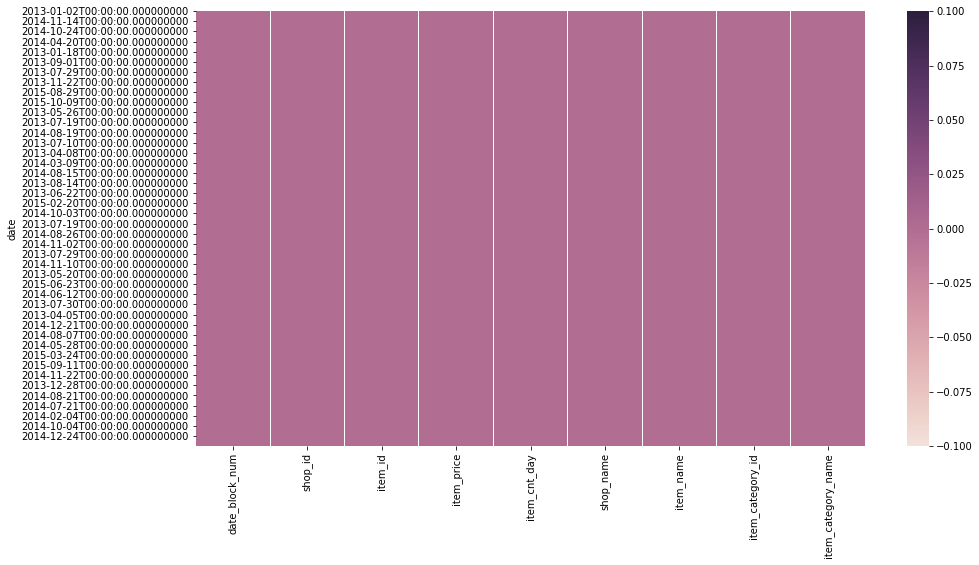

In [35]:
plt.figure(figsize = (15,8))
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
sns.heatmap(df.isnull(), cmap=cmap)

# Identifying the pattern of sales of Item and Item Category on Monthly basis

### Variation in Number of Shops/Month

Text(0.5, 1.0, 'Variation in Numbers of Shops/Month')

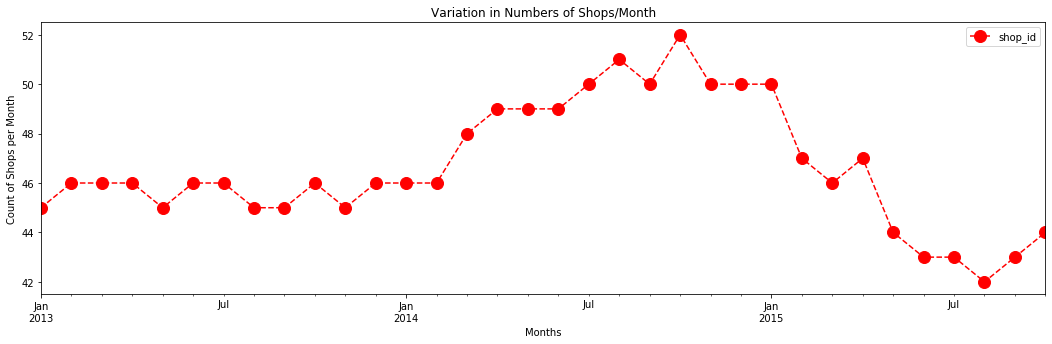

In [36]:

df.groupby(pd.Grouper(freq='M'))["shop_id"].nunique().plot(figsize = (18,5), legend = True, c="r" , ls= "--", marker = "o", markersize=12)
plt.xlabel("Months")
plt.ylabel("Count of Shops per Month")
plt.title("Variation in Numbers of Shops/Month")

### Variation in Number of Distinct Products sold/Month

Text(0.5, 1.0, 'Variation in Number of Distinct Products sold/Month')

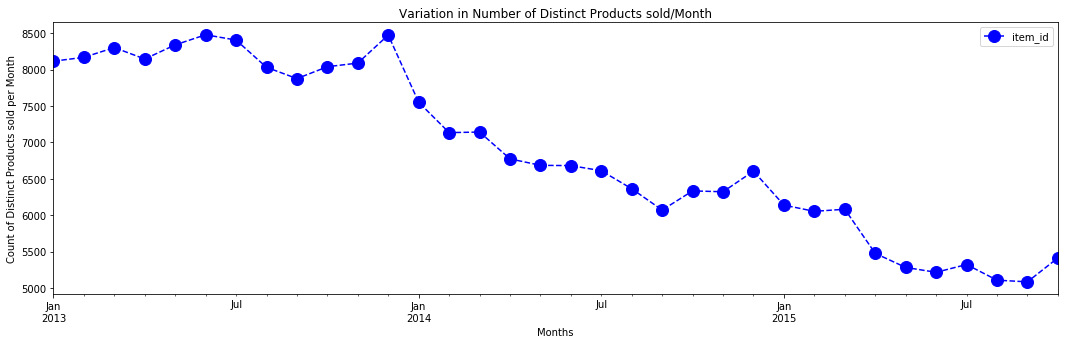

In [37]:
df.groupby(pd.Grouper(freq='M'))["item_id"].nunique().plot(figsize = (18,5), legend = True, c="b" , ls= "--", marker = "o", markersize=12)
plt.xlabel("Months")
plt.ylabel("Count of Distinct Products sold per Month")
plt.title("Variation in Number of Distinct Products sold/Month")

### No. of Distinct Items sold per Category

Text(0.5, 1.0, 'No. of Distinct Items sold per Category')

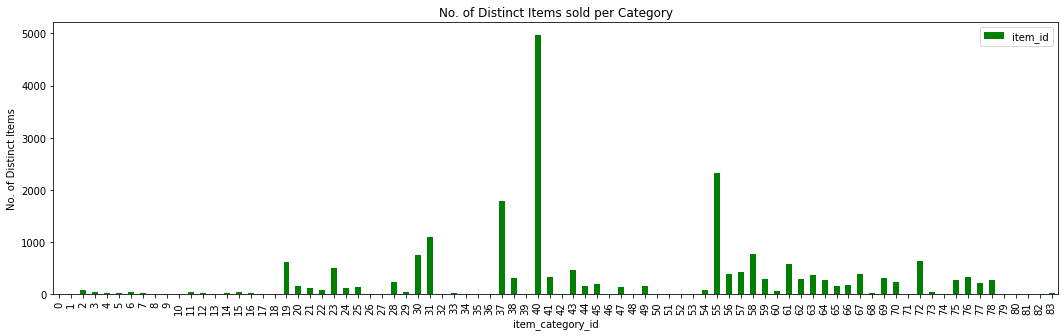

In [38]:
df.groupby("item_category_id")["item_id"].nunique().plot(kind = 'bar', legend = True, figsize = (18,5), color = 'green')
plt.xlabel("item_category_id")
plt.ylabel("No. of Distinct Items")
plt.title("No. of Distinct Items sold per Category")

### No. of Items sold per Category

Text(0.5, 1.0, 'No. of Items sold per Category')

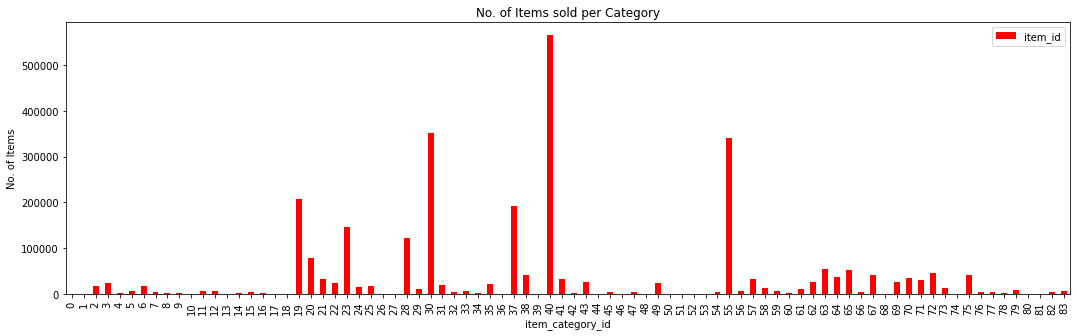

In [39]:
df.groupby("item_category_id")["item_id"].count().plot(kind = 'bar', legend = True, figsize = (18,5), color = 'red')
plt.xlabel("item_category_id")
plt.ylabel("No. of Items")
plt.title("No. of Items sold per Category")

### Variation in Number of Distinct Products Category sold/Month

Text(0.5, 1.0, 'Variation in Number of Distinct Products Category sold/Month')

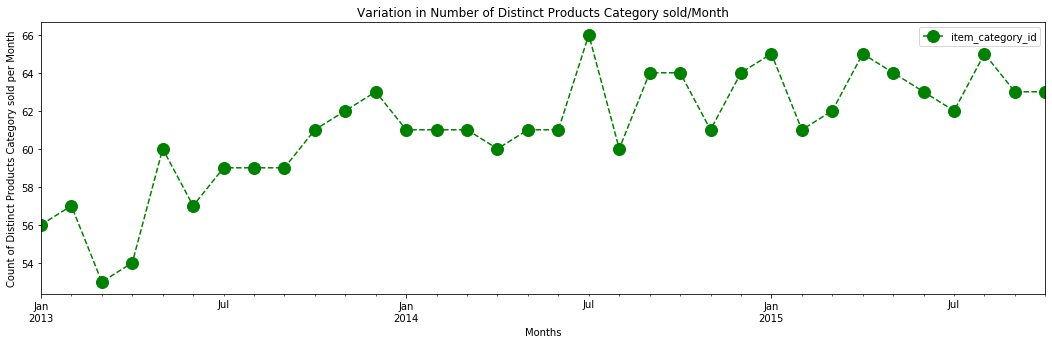

In [40]:

df.groupby(pd.Grouper(freq='M'))["item_category_id"].nunique().plot(figsize = (18,5), legend = True, c="g" , ls= "--", marker = "o", markersize=12)
plt.xlabel("Months")
plt.ylabel("Count of Distinct Products Category sold per Month")
plt.title("Variation in Number of Distinct Products Category sold/Month")

### Number of Distinct products sold by each shop/Month

Text(0.5, 1.0, 'Number of Distinct products sold by each shop/Month')

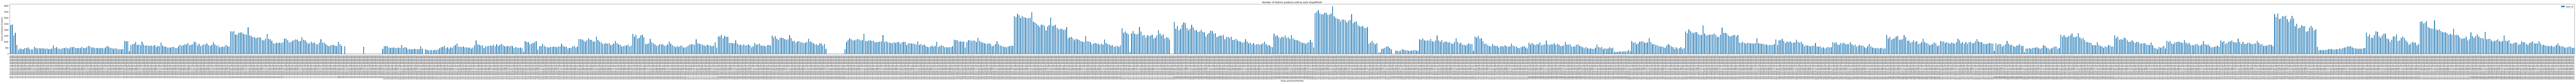

In [41]:
df.groupby("shop_id").resample("M")["item_id"].nunique().plot(kind = "bar", legend = True, figsize = (250,5))
plt.xlabel("Shops perfomed Monthly")
plt.ylabel("Count of Distinct Products")
plt.title("Number of Distinct products sold by each shop/Month")

# Creating the DataFrame and preparing it for TimeSeriesForacsting

In [42]:
item_cnt_data = df.groupby([pd.Grouper(freq = "M"),"shop_id","item_id"]).agg({"item_cnt_day":"sum"})

In [43]:
item_cnt_df = pd.DataFrame(item_cnt_data.values, index = item_cnt_data.index, columns = ["Count"])

In [44]:
item_cnt_df.head()

Count
date       shop_id item_id       
2013-01-31 0       32         6.0
                   33         3.0
                   35         1.0
                   43         1.0
                   51         2.0

In [45]:
item_cnt_df[item_cnt_df["Count"] == -22.0]

,,,Count
date,shop_id,item_id,
2013-11-30,12,8023,-22.0


In [46]:
req_data = df.groupby(["date_block_num","shop_id","item_id"]).agg({"item_cnt_day":"sum"})

In [47]:
req_data.head()

item_cnt_day
date_block_num shop_id item_id              
0              0       32                6.0
                       33                3.0
                       35                1.0
                       43                1.0
                       51                2.0

In [48]:
len(req_data)

1609124

In [49]:
type(req_data)

pandas.core.frame.DataFrame

## Checking for active shops in 2015

In [50]:
last_year_shop = item_cnt_df[item_cnt_df.index.get_level_values('date').year == 2015]

In [51]:
last_year_shop.head()

Count
date       shop_id item_id       
2015-01-31 2       67         1.0
                   786        1.0
                   792        1.0
                   806        1.0
                   949        1.0

In [52]:
def shp_id(df):
    lst = []
    for i in range(len(df)):
        lst.append(df.index[i][1])
    return lst
    

In [53]:
shop_lst = shp_id(last_year_shop)

In [54]:
shop_id = list(set(shop_lst))
for i in shop_id:
    print(i, end = " ")

2 3 4 5 6 7 9 10 11 12 14 15 16 17 18 19 20 21 22 24 25 26 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 

## Checking for items sold in 2014 and 2015

In [55]:
actv_item = item_cnt_df[np.in1d(item_cnt_df.index.get_level_values('date').year, [2014,2015])]

In [56]:
def itm_id(df):
    lst = []
    for i in range(len(df)):
        lst.append(df.index[i][2])
    return lst

In [57]:
item_lst = itm_id(actv_item)
item_id = list(set(item_lst))

In [58]:
len(item_id)

17054

In [59]:
temp = item_cnt_df.reset_index()

In [60]:
temp.head()

,date,shop_id,item_id,Count
0,2013-01-31,0,32,6.0
1,2013-01-31,0,33,3.0
2,2013-01-31,0,35,1.0
3,2013-01-31,0,43,1.0
4,2013-01-31,0,51,2.0


## Considering the shops and items which are active in 2014 and 2015

In [61]:
shop_item_id = [(x,y) for x,y in zip(temp['shop_id'],temp['item_id'])]

In [62]:
temp.set_index("date",inplace = True)

In [63]:
temp.head()

,shop_id,item_id,Count
date,,,
2013-01-31,0,32,6.0
2013-01-31,0,33,3.0
2013-01-31,0,35,1.0
2013-01-31,0,43,1.0
2013-01-31,0,51,2.0


In [64]:
active_shop_data = temp[temp["shop_id"].isin(shop_id)]

In [65]:
target_data = active_shop_data[active_shop_data["item_id"].isin(item_id)]

In [66]:
target_data.head()

,shop_id,item_id,Count
date,,,
2013-01-31,2,27,1.0
2013-01-31,2,33,1.0
2013-01-31,2,471,2.0
2013-01-31,2,481,1.0
2013-01-31,2,482,1.0


In [67]:
shop_item_id = list(zip(target_data["shop_id"],target_data["item_id"]))

In [68]:
len(shop_item_id)

1519298

In [69]:
target_data["shop_item_id"] = shop_item_id

C:\Users\Adarsh Singh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [70]:
target_data.head()

,shop_id,item_id,Count,shop_item_id
date,,,,
2013-01-31,2,27,1.0,"(2, 27)"
2013-01-31,2,33,1.0,"(2, 33)"
2013-01-31,2,471,2.0,"(2, 471)"
2013-01-31,2,481,1.0,"(2, 481)"
2013-01-31,2,482,1.0,"(2, 482)"


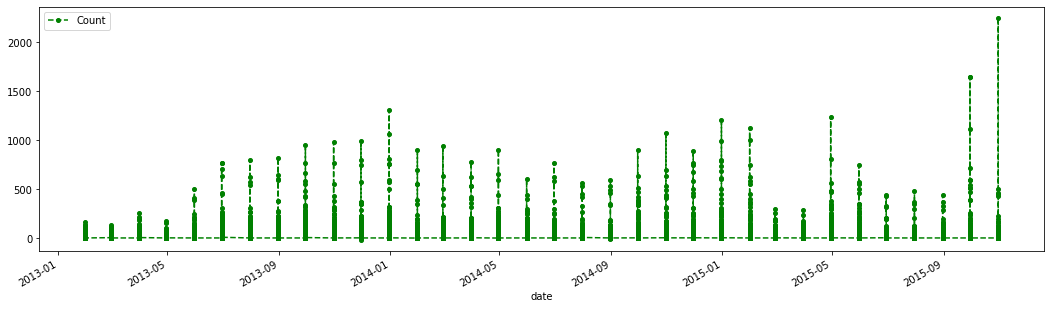

In [71]:
target_data["Count"].plot(figsize = (18,5), legend = True, c="g" , ls= "--", marker = "o", markersize=4)

In [72]:
print(target_data["Count"].min(),target_data["Count"].max(),target_data["Count"].mean())

-22.0 2253.0 2.3059887886047363


In [73]:
target_data = target_data[target_data["Count"] > 0]

## Checking for Outlier

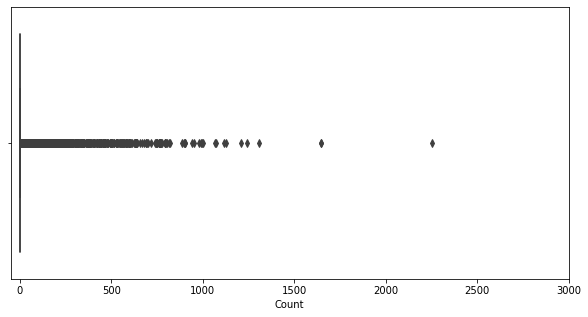

In [74]:
plt.figure(figsize = (10,5))
plt.xlim([-50,3000])
sns.boxplot(x = target_data.Count)

## Replacing the outlier values with 750

In [75]:
target_data.loc[target_data.Count > 1000, 'Count'] = 750

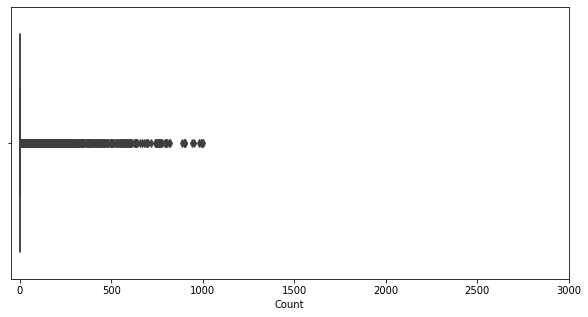

In [76]:
plt.figure(figsize = (10,5))
plt.xlim([-50,3000])
sns.boxplot(x = target_data.Count)

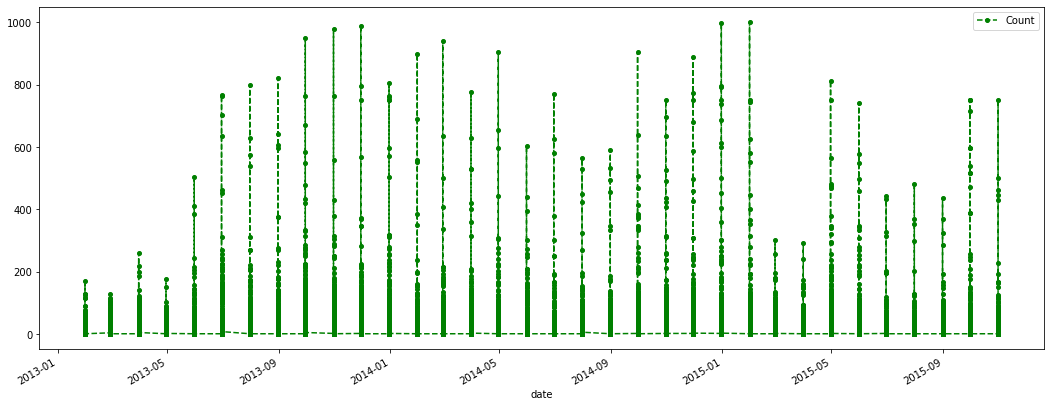

In [77]:
target_data["Count"].plot(figsize = (18,7), legend = True, c="g" , ls= "--", marker = "o", markersize=4)

In [78]:
train_data = pd.DataFrame(target_data['Count'])

In [79]:
train_data.head()

,Count
date,
2013-01-31,1.0
2013-01-31,1.0
2013-01-31,2.0
2013-01-31,1.0
2013-01-31,1.0


In [80]:
train_data = pd.DataFrame(train_data.groupby([pd.Grouper(freq = 'M')])['Count'].sum())

In [81]:
train_data.head()

,Count
date,
2013-01-31,101264.0
2013-02-28,100686.0
2013-03-31,126448.0
2013-04-30,93538.0
2013-05-31,96727.0


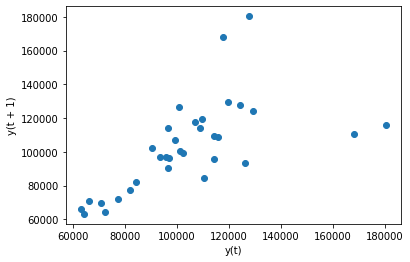

In [82]:
pd.plotting.lag_plot(train_data,lag = 1)

# Checking the stationarity of the trend

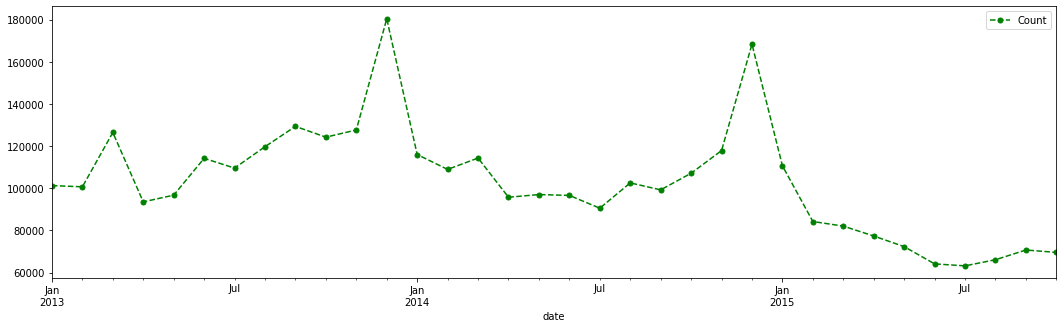

In [83]:
train_data.plot(figsize = (18,5), legend = True, c="g" , ls= "--", marker = "o", markersize=5)

In [84]:
from statsmodels.tsa.stattools import adfuller
def ad_fuller(df):
    stat_result = adfuller(df)
    labels = ["ADF Test Statistics","P-Value","Lag Used","No. of Observation Used"]
    for label,value in zip(labels,stat_result):
        print(label+" :- "+str(value))

In [85]:
ad_fuller(train_data["Count"])

ADF Test Statistics :- -2.4803649134363006
P-Value :- 0.12032513712630549
Lag Used :- 0
No. of Observation Used :- 33


### As per the p values, the trend is not stationary, hence taking the seasonal difference to get rid of it

In [86]:
train_data["Seosonal difference"] = train_data["Count"] - train_data["Count"].shift(1)

In [87]:
train_data

,Count,Seosonal difference
date,,
2013-01-31,101264.0,NaN
2013-02-28,100686.0,-578.0
2013-03-31,126448.0,25762.0
2013-04-30,93538.0,-32910.0
2013-05-31,96727.0,3189.0
2013-06-30,114182.0,17455.0
2013-07-31,109560.0,-4622.0
2013-08-31,119713.0,10153.0
2013-09-30,129343.0,9630.0


In [88]:
ad_fuller(train_data["Seosonal difference"].dropna())

ADF Test Statistics :- -7.968613970795442
P-Value :- 2.8205631294723528e-12
Lag Used :- 10
No. of Observation Used :- 22


### As per the p values now trend has become stationary

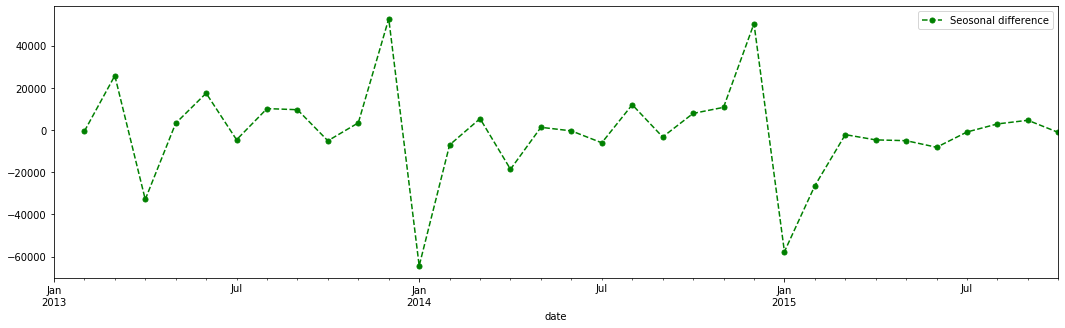

In [89]:
train_data["Seosonal difference"].plot(figsize = (18,5), legend = True, c="g" , ls= "--", marker = "o", markersize=5)

# Finding the p, q values for ARIMA model

In [90]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

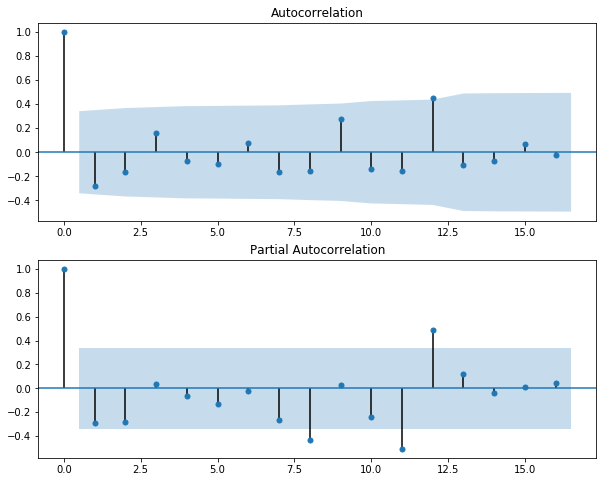

In [91]:
fig = plt.figure(figsize= (10,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_data['Seosonal difference'].iloc[1:],ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_data['Seosonal difference'].iloc[1:],ax=ax2)

In [92]:
from datetime import datetime
from datetime import timedelta
train_end = datetime(2014,12,31)
test_end = datetime(2015,10,31)
trn = train_data[:train_end]
tst = train_data[train_end + timedelta(days=1):test_end]

In [93]:
tst

,Count,Seosonal difference
date,,
2015-01-31,110633.0,-57684.0
2015-02-28,84228.0,-26405.0
2015-03-31,82039.0,-2189.0
2015-04-30,77359.0,-4680.0
2015-05-31,72309.0,-5050.0
2015-06-30,64128.0,-8181.0
2015-07-31,63199.0,-929.0
2015-08-31,66094.0,2895.0
2015-09-30,70714.0,4620.0


# Building an ARIMA model and fitting the data and predicting the trend

In [94]:
from statsmodels.tsa.arima_model import ARIMA

In [95]:
ar_mod = ARIMA(trn['Seosonal difference'].dropna(), order=(1,1,0))
ar_mod_fit = ar_mod.fit()


In [96]:
ar_mod_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARIMA Model Results                               
=================================================================================
Dep. Variable:     D.Seosonal difference   No. Observations:                   22
Model:                    ARIMA(1, 1, 0)   Log Likelihood                -258.038
Method:                          css-mle   S.D. of innovations          29759.419
Date:                   Mon, 05 Jul 2021   AIC                            522.076
Time:                           17:41:30   BIC                            525.349
Sample:                       03-31-2013   HQIC                           522.847
                            - 12-31-2014                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        1184.7983   4098.663      0.289      0.773   -6848.433    9218.030
ar.L1.D.Seosonal difference    -0.5761      0.172     -3.343      0.001      -0.914      -0.238
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.7359           +0.0000j            1.7359            0.5000
-----------------------------------------------------------------------------
"""

### As per the p value of model, it is valid to predict the trend

In [97]:
pred_start_date = tst.index[0]
pred_end_date = tst.index[-1]

In [98]:
predictions = ar_mod_fit.predict(start=pred_start_date, end=pred_end_date)

In [99]:
res = tst['Seosonal difference'] - predictions
print(res)

date
2015-01-31   -36674.413007
2015-02-28   -40375.661322
2015-03-31     3991.951711
2015-04-30   -10108.099894
2015-05-31    -3790.293864
2015-06-30   -10774.041790
2015-07-31    -1302.529664
2015-08-31     1242.841635
2015-09-30     3704.441060
2015-10-31    -2490.903171
Freq: M, dtype: float64


Text(0, 0.5, 'Error')

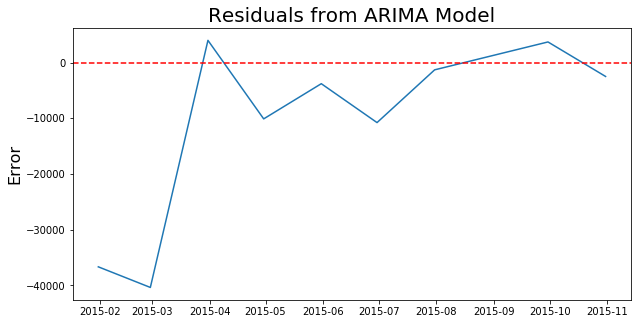

In [100]:
plt.figure(figsize = (10,5))
plt.plot(res)
plt.axhline(0, linestyle = "--", color = 'r')
plt.title('Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

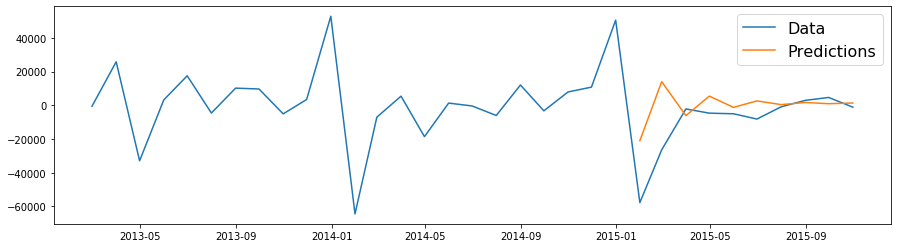

In [101]:
plt.figure(figsize=(15,4))

plt.plot(train_data['Seosonal difference'])
plt.plot(predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)


In [102]:
print('Mean Absolute Percent Error:', round(np.mean(abs(res/tst['Seosonal difference'])),4))

Mean Absolute Percent Error: 1.3013


In [103]:
print('Root Mean Squared Error:', np.sqrt(np.mean(res**2)))

Root Mean Squared Error: 18019.24244697329


In [104]:
from pandas.tseries.offsets import DateOffset
future_dates = [tst.index[-1]+ DateOffset(months=x)for x in range(0,3)]

In [105]:
future_datest_df = pd.DataFrame(index=future_dates[1:], columns=tst.columns)

In [106]:
future_datest_df

,Count,Seosonal difference
2015-11-30,NaN,NaN
2015-12-31,NaN,NaN


In [107]:
future_df=pd.concat([tst,future_datest_df])
future_df

,Count,Seosonal difference
2015-01-31,110633.0,-57684.0
2015-02-28,84228.0,-26405.0
2015-03-31,82039.0,-2189.0
2015-04-30,77359.0,-4680.0
2015-05-31,72309.0,-5050.0
2015-06-30,64128.0,-8181.0
2015-07-31,63199.0,-929.0
2015-08-31,66094.0,2895.0
2015-09-30,70714.0,4620.0
2015-10-31,69563.0,-1151.0


In [108]:
pred_start_date_df = future_df.index[0]
pred_end_date_df = future_df.index[-1]

In [109]:
pred_df = ar_mod_fit.predict(start=pred_start_date_df, end=pred_end_date_df)

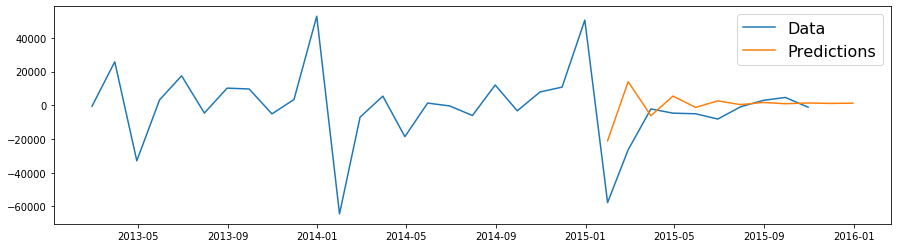

In [110]:
plt.figure(figsize=(15,4))
plt.plot(train_data['Seosonal difference'])
plt.plot(pred_df)
plt.legend(('Data', 'Predictions'), fontsize=16)

In [111]:
data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,2013-01-02,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-01-02,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,2013-01-03,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,2013-01-20,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,2013-01-23,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


In [112]:
target_df = data[["date_block_num","shop_id","item_id","item_category_id","item_cnt_day"]]

In [113]:
target_df.head()

,date_block_num,shop_id,item_id,item_category_id,item_cnt_day
0,0,59,22154,37,1.0
1,0,25,22154,37,1.0
2,0,25,22154,37,1.0
3,0,25,22154,37,1.0
4,0,25,22154,37,1.0


In [114]:
target_data = target_data.reset_index()

In [115]:
fin_data = pd.merge(target_data,item_data,on = "item_id")

In [116]:
fin_data.head()

,date,shop_id,item_id,Count,shop_item_id,item_name,item_category_id
0,2013-01-31,2,27,1.0,"(2, 27)","007 Legends [PS3, русская версия]",19
1,2013-01-31,10,27,1.0,"(10, 27)","007 Legends [PS3, русская версия]",19
2,2013-01-31,19,27,1.0,"(19, 27)","007 Legends [PS3, русская версия]",19
3,2013-01-31,26,27,1.0,"(26, 27)","007 Legends [PS3, русская версия]",19
4,2013-01-31,31,27,1.0,"(31, 27)","007 Legends [PS3, русская версия]",19


In [117]:
fin_data.drop(["item_name"],axis = 1, inplace = True)

In [118]:
fin_data.head()

,date,shop_id,item_id,Count,shop_item_id,item_category_id
0,2013-01-31,2,27,1.0,"(2, 27)",19
1,2013-01-31,10,27,1.0,"(10, 27)",19
2,2013-01-31,19,27,1.0,"(19, 27)",19
3,2013-01-31,26,27,1.0,"(26, 27)",19
4,2013-01-31,31,27,1.0,"(31, 27)",19


In [119]:
fin_data["month"] = fin_data["date"].dt.month

In [120]:
fin_data.head()

,date,shop_id,item_id,Count,shop_item_id,item_category_id,month
0,2013-01-31,2,27,1.0,"(2, 27)",19,1
1,2013-01-31,10,27,1.0,"(10, 27)",19,1
2,2013-01-31,19,27,1.0,"(19, 27)",19,1
3,2013-01-31,26,27,1.0,"(26, 27)",19,1
4,2013-01-31,31,27,1.0,"(31, 27)",19,1


In [121]:
mod_data = fin_data[["shop_id","item_id","item_category_id","month","Count"]]

In [122]:
mod_data.head()

,shop_id,item_id,item_category_id,month,Count
0,2,27,19,1,1.0
1,10,27,19,1,1.0
2,19,27,19,1,1.0
3,26,27,19,1,1.0
4,31,27,19,1,1.0


## Correlation plot

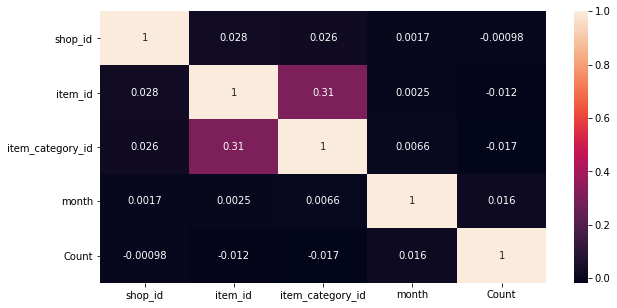

In [123]:
plt.figure(figsize = (10,5))
sns.heatmap(mod_data.corr(), annot = True)

In [124]:
x = mod_data[["shop_id","item_id","item_category_id","month"]]
y = mod_data["Count"]

In [125]:
x.head()

,shop_id,item_id,item_category_id,month
0,2,27,19,1
1,10,27,19,1
2,19,27,19,1
3,26,27,19,1
4,31,27,19,1


In [126]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 101)

In [127]:
len(x_test)

454792

# Tuning the Random Forest Model

In [128]:
from sklearn.model_selection import RandomizedSearchCV

parameters_for_testing = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'max_depth':[3,4,5],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [100, 200, 500]}

In [129]:
from sklearn.ensemble import RandomForestRegressor

In [130]:
model = RandomForestRegressor()

In [131]:
model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [132]:
random_cv = RandomizedSearchCV(estimator= model, param_distributions = parameters_for_testing, cv=3, n_iter = 50, n_jobs=4, verbose=5,scoring='neg_mean_absolute_error', return_train_score = True, random_state = 42)

In [133]:
random_cv.fit(x_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 27.5min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 111.5min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed: 254.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [134]:
random_cv.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [135]:
model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [136]:
model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [137]:
prediction = model.predict(x_test)

In [138]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, prediction))

In [139]:
rms

6.87741105508433

In [140]:
test_data.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [141]:
test_data["tuple"] = list(zip(test_data["shop_id"],test_data["item_id"]))

In [142]:
len(test_data)

214200

In [143]:
future_count = pd.merge(test_data,item_data,on = "item_id")

In [144]:
future_count.head()

,ID,shop_id,item_id,tuple,item_name,item_category_id
0,0,5,5037,"(5, 5037)","NHL 15 [PS3, русские субтитры]",19
1,5100,4,5037,"(4, 5037)","NHL 15 [PS3, русские субтитры]",19
2,10200,6,5037,"(6, 5037)","NHL 15 [PS3, русские субтитры]",19
3,15300,3,5037,"(3, 5037)","NHL 15 [PS3, русские субтитры]",19
4,20400,2,5037,"(2, 5037)","NHL 15 [PS3, русские субтитры]",19


In [145]:
future_data = future_count[["shop_id","item_id","item_category_id"]]

In [146]:
len(future_data)

214200

In [147]:
future_data["month"] = [11]*(214200)

C:\Users\Adarsh Singh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [148]:
future_data.head()

,shop_id,item_id,item_category_id,month
0,5,5037,19,11
1,4,5037,19,11
2,6,5037,19,11
3,3,5037,19,11
4,2,5037,19,11


In [149]:
result = model.predict(future_data)

In [150]:
future_data["result"] = result

C:\Users\Adarsh Singh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [151]:
future_data.head()

,shop_id,item_id,item_category_id,month,result
0,5,5037,19,11,2.845187
1,4,5037,19,11,2.845187
2,6,5037,19,11,2.845187
3,3,5037,19,11,2.845187
4,2,5037,19,11,2.845187


In [152]:
print(future_data["result"].max(),"\n",future_data["result"].min(),"\n",future_data["result"].mean(),"\n",future_data["result"].sum())

429.6658978289667 
 1.3722390076647761 
 2.235369813719085 
 478816.2140990041


In [153]:
pred_df

2015-01-31   -21009.586993
2015-02-28    13970.661322
2015-03-31    -6180.951711
2015-04-30     5428.099894
2015-05-31    -1259.706136
2015-06-30     2593.041790
2015-07-31      373.529664
2015-08-31     1652.158365
2015-09-30      915.558940
2015-10-31     1339.903171
2015-11-30     1095.444622
2015-12-31     1236.273642
Freq: M, dtype: float64

# Tuning the XGBoost model

In [154]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [155]:
model_xgb = xgb.XGBRegressor()

In [156]:
parameters_for_xgb = {
    'colsample_bytree':[0.4,0.6,0.8],
    'gamma':[0,0.03,0.1,0.3],
    'min_child_weight':[1.5,3,6,10],
    'learning_rate':[0.07,0.1,0.15,0.2],
    'max_depth':[3,4,5],
    'n_estimators':[100,250,500,700,1000,1500],
    'subsample':[0.6,0.95],
    'booster': ['gbtree','gblinear'],
    'base_score': [0.25,0.5,0.75,1]
}

In [157]:
random_xgb = RandomizedSearchCV(estimator= model_xgb, param_distributions = parameters_for_testing, cv=3, n_iter = 50, n_jobs=4, verbose=5,scoring='neg_mean_absolute_error', return_train_score = True, random_state = 42)

In [158]:
random_xgb.fit(x_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 16.1min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 69.0min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed: 206.1min finished


[01:35:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                                          seed=None, silent=None, subsample=1,
                                          verbosity=1),
                   iid='deprecated', n_iter=50, n_job

In [159]:
random_xgb.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', bootstrap=False,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=5, max_features='auto',
             min_child_weight=1, min_samples_split=5, missing=None,
             n_estimators=500, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [160]:
model_xgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree', bootstrap=False,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=5, max_features='auto',
             min_child_weight=1, min_samples_split=5, missing=None,
             n_estimators=500, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [161]:
model_xgb.fit(x_train, y_train)

[02:09:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', bootstrap=False,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=5, max_features='auto',
             min_child_weight=1, min_samples_split=5, missing=None,
             n_estimators=500, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [162]:
trial = model_xgb.predict(x_test)

In [163]:
sqrt(mean_squared_error(y_test, trial))

5.69919164179211

In [164]:
xgb_res = model_xgb.predict(future_data[['shop_id', 'item_id', 'item_category_id', 'month']])

In [165]:
future_data["res"] = xgb_res

In [166]:
future_data["res"].sum()

507784.56

In [167]:
future_data["res"].max()

601.387451171875

In [168]:
future_data["res"].mean()

2.3705551624298096

In [169]:
future_data.head()

,shop_id,item_id,item_category_id,month,result,res
0,5,5037,19,11,2.845187,1.398419
1,4,5037,19,11,2.845187,1.398419
2,6,5037,19,11,2.845187,2.536565
3,3,5037,19,11,2.845187,1.274716
4,2,5037,19,11,2.845187,1.746982


In [170]:
future_data["tuple"] = list(zip(future_data["shop_id"],future_data["item_id"]))

In [171]:
future_data.head()

,shop_id,item_id,item_category_id,month,result,res,tuple
0,5,5037,19,11,2.845187,1.398419,"(5, 5037)"
1,4,5037,19,11,2.845187,1.398419,"(4, 5037)"
2,6,5037,19,11,2.845187,2.536565,"(6, 5037)"
3,3,5037,19,11,2.845187,1.274716,"(3, 5037)"
4,2,5037,19,11,2.845187,1.746982,"(2, 5037)"


In [172]:
future_data = pd.merge(future_data,test_data,on = "tuple")

## Based on the sum of Sales of Items choosing the predction from Random Forest Model

In [173]:
submission = future_data[["ID","res"]]

In [174]:
submission.sort_values("ID", inplace = True)

C:\Users\Adarsh Singh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [175]:
submission.set_index("ID",inplace = True)

# Storing the prediction in desired location

In [176]:
submission.to_csv("sample_submission.csv")